In [47]:
from config.query import BigQueryClient
from config.config import TABLES

In [4]:
bq = BigQueryClient()

In [48]:
A = bq.get_dataframe(TABLES['A'])

In [7]:
import ast

# Convert string representations of dictionaries to actual dictionaries, then sum their values
A['totalTvls'] = A['currentChainTvls'].apply(lambda x: sum(ast.literal_eval(x).values()) if isinstance(x, str) and x.strip() != '' else 0)

# Sort A by 'totalTvls', descending
A = A.sort_values(by='totalTvls', ascending=False)

In [6]:
query = f"SELECT DISTINCT token_name FROM `{bq.dataset_ref.dataset_id}.{TABLES['C']}`"

unique_token_names = bq.client.query(query).to_dataframe()

# establish mapping
- rev_map
    - this is the easiest case, we can just use the coin id from the mapping
- LP
    - need to think more, might need to consider bridge
- UNKNOWN
    - a common cell here is UNKNOWN (heco:0x5eE41aB6edd38cDfB9f6B4e6Cf7F75c87E170d98)
    - this follows UNKNOWN (X:Y)
    - the X:Y mapping identifies Y as the search source, we utilize Y to find the protocol id
- Other
    - major custodial protocols, need to be handled manually


In [10]:
query = f"""
SELECT token_name, COUNT(*) as frequency
FROM `{bq.dataset_ref.dataset_id}.{TABLES['C']}`
GROUP BY token_name
ORDER BY frequency DESC
"""

# Execute the query and retrieve the DataFrame
frequency_df = bq.client.query(query).to_dataframe()

handle MAP

In [11]:
import json
import pandas as pd

rev_map = {}

for idx, row in A.iterrows():
    if pd.notna(row['assetToken']) and row['assetToken'] != "-":
        rev_map[row['assetToken']] = row['id']
    if pd.notna(row['symbol']) and row['symbol'] != "-":
        rev_map[row['symbol']] = row['id']

with open('config/rev_map.json', 'w') as json_file:
    # Use json.dump() to write the rev_map dictionary to the file
    json.dump(rev_map, json_file, indent=4)

In [12]:
frequency_dict = frequency_df.set_index('token_name')['frequency'].to_dict()

unique_token_names = unique_token_names.dropna()

categories = {'MAP': {}, 'LP': {}, 'UNKNOWN': {}, 'PRIMARY': {}, 'OTHER': {}}

for index, row in unique_token_names.iterrows():
    token_name = row['token_name']
    category = ''
    if token_name in rev_map:
        category = 'MAP'
    elif "LP" in token_name:
        category = 'LP'
    elif "UNKNOWN" in token_name:
        category = 'UNKNOWN'
    elif "-" in token_name:
        category = 'OTHER'
    else:
        category = 'PRIMARY'
    # Include frequency along with id in the dictionary
    categories[category][token_name] = {
        'id': rev_map.get(token_name, None),
        'frequency': frequency_dict.get(token_name, 0)  # Default to 0 if not found
    }

handle LP

In [ ]:
categories['LP']

{'2SHARES-WFTM-SPLP': {'id': None, 'frequency': 11536},
 'AXIAL-WAVAX-JLP': {'id': None, 'frequency': 4662},
 'WBNB-USDT-CAKE-LP': {'id': None, 'frequency': 12834},
 'WBNB-DUEL-CAKE-LP': {'id': None, 'frequency': 11344},
 'WFTM-YOSHI-SPIRIT-LP': {'id': None, 'frequency': 5448},
 'PTESTLP': {'id': None, 'frequency': 5448},
 'BSHARE-WFTM-SPLP': {'id': None, 'frequency': 5448},
 'TUSD-BUSD-BSW-LP': {'id': None, 'frequency': 21926},
 'LPOOL': {'id': None, 'frequency': 17370},
 'WBNB-PALM-CAKE-LP': {'id': None, 'frequency': 4986},
 'STSOL-WSOL-SABER-LP': {'id': None, 'frequency': 4402},
 'WSOL-ZSOL-SABER-LP': {'id': None, 'frequency': 1400},
 'CRV-WETH-SLP': {'id': None, 'frequency': 1734},
 'RARI-WETH-SLP': {'id': None, 'frequency': 1734},
 'BUSD-ALPACA-CAKE-LP': {'id': None, 'frequency': 8170},
 'WFTM-KNGFUU-SPLP': {'id': None, 'frequency': 1070},
 'ANY-WFTM-SPLP': {'id': None, 'frequency': 11860},
 'WAVAX-FEED-JLP': {'id': None, 'frequency': 5584},
 'WPLS-PLSX-PLP': {'id': None, 'frequen

handle UNKNOWN

In [ ]:
categories['UNKNOWN']

{'UNKNOWN (avax:0x3eab2111dFc8DbEe0e1e1F0b4F3eAA99523f9E2e)': {'id': None,
  'frequency': 1572},
 'UNKNOWN (avax:0xE9476e16FE488B90ada9Ab5C7c2ADa81014Ba9Ee)': {'id': None,
  'frequency': 1572},
 'UNKNOWN (harmony:0x26b4145303da37a3fbabe8ff7696c7d5510207bb)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0x9f6d97dd4f57b139a9c516a222fc78da751226cf)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xd6ca29f43ece5e5367b2147655b76310cbeb66c3)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xcffa951d31cec708bd33272bc2cd7ac5af72a26e)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xa71ebb88d300d4ab9fd16e8c587a2799b0f0e71f)': {'id': None,
  'frequency': 13202},
 'UNKNOWN (harmony:0x39927a2cee5580d63a163bc402946c7600300373)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0x600541ad6ce0a8b5dae68f086d46361534d20e80)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (fantom:0x68f7880f7af43a81bef25e2ae83802eb6c2ddbfd)': {'id': None,
  'frequency': 5448},
 'UNKN

handle OTHER

In [ ]:
categories['OTHER']

{'KT1UsSfaXyqcjSVPeiD7U1bWgKy3taYN7NWY-8': {'id': None, 'frequency': 982},
 'KT1AFq5XorPduoYyWxs5gEyrFK6fVjJVbtCj-4538': {'id': None, 'frequency': 982},
 'WAVAX-ORCA-PGL': {'id': None, 'frequency': 10246},
 'WAVAX-UST-PGL': {'id': None, 'frequency': 10246},
 'BUSD3CRV-F': {'id': None, 'frequency': 10264},
 'REALTOKEN-S-8056-E-HOLLYWOOD-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-5278-5280-DREXEL-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-4456-FAIRVIEW-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALT-S-9309-COURVILLE-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALT-S-9133-DEVONSHIRE-RD-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-10862-MARNE-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-18286-OAKFIELD-AVE-DETROIT-MI': {'id': None, 'frequency': 5352},
 'GUSDFRAXBP3CRV-F': {'id': None, 'frequency': 8820},
 'ACRV-F': {'id': None, 'frequency': 10720},
 'WETH-CEL-UNI-V2': {'id': None, 'frequency': 2036},
 

In [ ]:
# Initialize two lists to hold tokens with and without hyphens
tokens_with_hyphen = []
tokens_without_hyphen = []

# Iterate through the tokens in the 'Other' category
for token_name in categories["OTHER"]:
    if '-' in token_name:
        tokens_with_hyphen.append(token_name)
    else:
        tokens_without_hyphen.append(token_name)

# Analysis results
print(f"Total tokens in 'Other': {len(categories['OTHER'])}")
print(f"Tokens with hyphen: {len(tokens_with_hyphen)}")
print(f"Tokens without hyphen: {len(tokens_without_hyphen)}")

Total tokens in 'Other': 9814
Tokens with hyphen: 1957
Tokens without hyphen: 7857


analysis

In [ ]:
import matplotx
import matplotlib.pyplot as plt
plt.style.use(matplotx.styles.dracula)

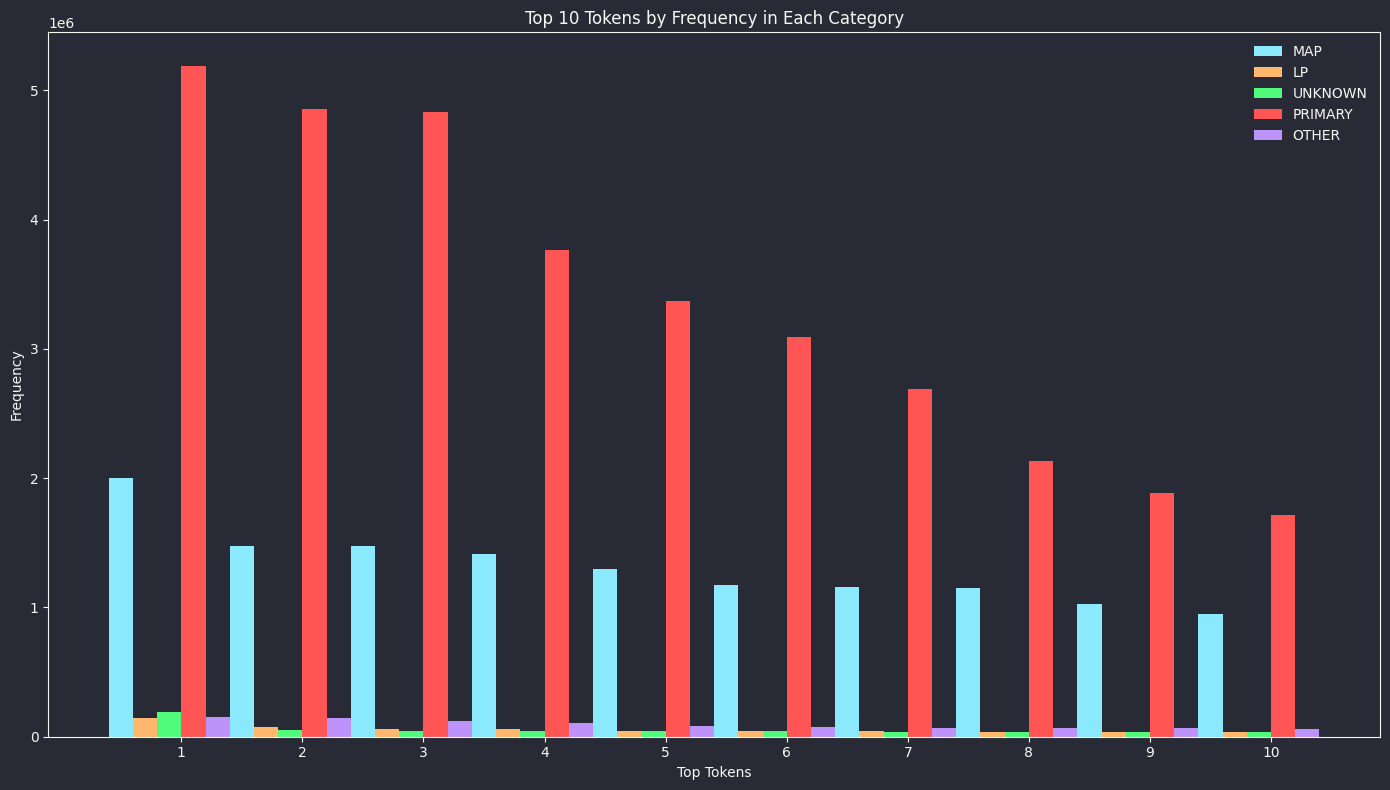

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plot_data = {category: sorted(categories[category].items(), key=lambda x: x[1]['frequency'], reverse=True)[:10] for category in categories}

fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.2
for i, (category, tokens) in enumerate(plot_data.items()):
    index = np.arange(len(tokens))
    frequencies = [token[1]['frequency'] for token in tokens]
    plt.bar(index + i*bar_width, frequencies, bar_width, label=category)

plt.xlabel('Top Tokens')
plt.ylabel('Frequency')
plt.title('Top 10 Tokens by Frequency in Each Category')
plt.xticks(index + bar_width * len(plot_data) / 2, range(1, len(tokens) + 1))
plt.legend()

plt.tight_layout()
plt.show()

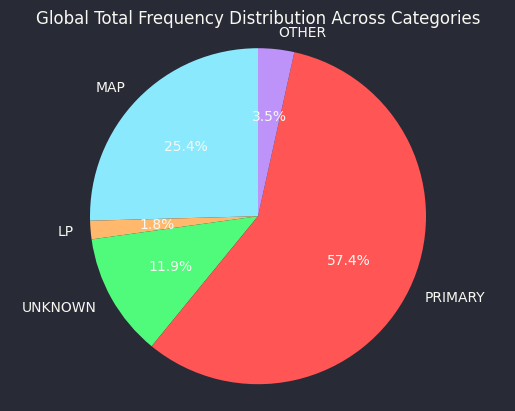

In [ ]:
import matplotlib.pyplot as plt

# Calculate sum frequencies for each category without using the trimmed plot_data
sum_frequencies = [sum(token['frequency'] for token in categories[category].values()) for category in categories]

# Generate labels with category names
labels = list(categories.keys())

# Calculate global total frequency to determine the percentage distribution
global_total_frequency = sum(sum_frequencies)

# Calculate percentage of each category's frequency from the global total
category_percentages = [(freq / global_total_frequency) * 100 for freq in sum_frequencies]

fig, ax = plt.subplots()
ax.pie(category_percentages, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Ensure pie is drawn as a circle.
plt.title('Global Total Frequency Distribution Across Categories')
plt.show()

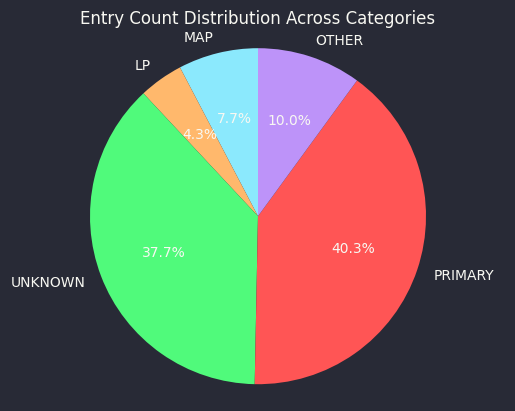

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of entries in each category
entry_counts = [len(categories[category]) for category in categories]

labels = list(categories.keys())

fig, ax = plt.subplots()
ax.pie(entry_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Ensure pie is drawn as a circle.
plt.title('Entry Count Distribution Across Categories')
plt.show()

the above plots show that if we locate the protocol originator of PRIMARY, plus MAP which we already know, we would cover most of the data

# handle primary

manual handling

In [27]:
sorted_primary = sorted(categories['PRIMARY'].items(), key=lambda x: x[1]['frequency'], reverse=True)
categories['PRIMARY'] = {token: data for token, data in sorted_primary}

In [13]:
top_100_tokens = sorted(categories['PRIMARY'].items(), key=lambda x: x[1]['frequency'], reverse=True)[:100]
top_100_tokens[:10]
# manually map this top_100_tokens and store in PRIMARY_TOKEN_TO_PROTOCOL

[('USDC', {'id': None, 'frequency': 5188196}),
 ('USDT', {'id': None, 'frequency': 4854532}),
 ('WETH', {'id': None, 'frequency': 4828746}),
 ('DAI', {'id': None, 'frequency': 3764458}),
 ('WBTC', {'id': None, 'frequency': 3370098}),
 ('ETH', {'id': None, 'frequency': 3093648}),
 ('BUSD', {'id': None, 'frequency': 2690146}),
 ('WBNB', {'id': None, 'frequency': 2131656}),
 ('USDC.E', {'id': None, 'frequency': 1886614}),
 ('BNB', {'id': None, 'frequency': 1715842})]

In [14]:
from config.config import PRIMARY_TOKEN_TO_PROTOCOL
import pandas as pd

In [30]:
matched_count = 0
unmatched_count = 0

for token, protocol_name in PRIMARY_TOKEN_TO_PROTOCOL.items():
    matching_row = A[A['name'] == protocol_name]
    
    if not matching_row.empty:
        matching_id = matching_row.iloc[0]['id']
        
        if token in categories['PRIMARY']:
            categories['PRIMARY'][token]['id'] = matching_id
            matched_count += 1
    else:
        unmatched_count += 1

In [33]:
for category_name, tokens in categories.items():
    for token, data in tokens.items():
        if data['id'] is None:
            if category_name == 'PRIMARY':
                categories[category_name][token]['id'] = token  # Fill in the token name if category is PRIMARY
            else:
                categories[category_name][token]['id'] = category_name

In [37]:
import json
import numpy as np

def default_handler(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Save the updated categories dictionary to a local JSON file
with open('config/token_to_protocol_mapping.json', 'w') as json_file:
    json.dump(categories, json_file, indent=4, default=default_handler)

# similarity score

- read ummapped tokens
- find the most similar token in the mapping
- if the similarity score is high, we can use the mapping
- update and overwrite the old mapping

In [104]:
import json
file_path = 'config/token_to_protocol_mapping.json'
with open(file_path, 'r') as json_file:
    categories = json.load(json_file)

In [39]:
A['all_text'] = A.apply(lambda x: ' '.join(x.fillna('').replace('None', '').astype(str)), axis=1)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast

input_tokens = {}

for category_name, tokens in categories.items():
    for token, data in tokens.items():
        if isinstance(data['id'], str):  # Check if 'id' is a string
            input_tokens[token] = data

# Now, input_tokens can be used as the input
input = input_tokens

# Extract token names from the input dictionary keys
token_names = list(input.keys())

# Combine token names and all concatenated texts from Table A
combined_texts = token_names + A['all_text'].tolist()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined texts to TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Split the matrix back into token names and Table A texts
tfidf_tokens = tfidf_matrix[:len(token_names)]
tfidf_A_texts = tfidf_matrix[len(token_names):]

# Calculate cosine similarity
similarity_scores = cosine_similarity(tfidf_tokens, tfidf_A_texts)

# Find the index of the best matching row in A for each token and the best scores
best_matches_indices = similarity_scores.argmax(axis=1)
best_scores = similarity_scores.max(axis=1)

# Assuming a threshold for minimum acceptable similarity (e.g., 0.2)
threshold = 0.3

# Initialize the mapping dictionary
TOKEN_TO_PROTOCOL_MAPPING = {}

# Populate the mapping dictionary
for i, token_name in enumerate(token_names):
    if best_scores[i] >= threshold:
        best_match_index = best_matches_indices[i]
        # Extract the id and name from A for the best match
        matched_id = A.iloc[best_match_index]['id']
        matched_name = A.iloc[best_match_index]['name']
        TOKEN_TO_PROTOCOL_MAPPING[token_name] = {'id': matched_id, 'name': matched_name}
    else:
        # Note the low confidence in mapping
        TOKEN_TO_PROTOCOL_MAPPING[token_name] = 'Low confidence in mapping; not mapped to a row in Table A.'

# Initialize two dictionaries: one for mapped tokens and one for tokens not mapped due to low confidence
mapped_tokens = {}
unmapped_tokens = {}

# Iterate through the TOKEN_TO_PROTOCOL_MAPPING to separate mapped and unmapped tokens
for token_name, mapping_info in TOKEN_TO_PROTOCOL_MAPPING.items():
    if isinstance(mapping_info, dict):
        # If the mapping_info is a dictionary, it means the token was successfully mapped
        mapped_tokens[token_name] = mapping_info
    else:
        # If the mapping_info is not a dictionary, it indicates low confidence in mapping
        unmapped_tokens[token_name] = mapping_info

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast

def similarity_scores(categories, A):
    input_tokens = {}
    for category_name, tokens in categories.items():
        for token, data in tokens.items():
            if isinstance(data['id'], str):
                input_tokens[token] = data

    token_names = list(input_tokens.keys())
    combined_texts = token_names + A['all_text'].tolist()
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_texts)
    tfidf_tokens = tfidf_matrix[:len(token_names)]
    tfidf_A_texts = tfidf_matrix[len(token_names):]
    similarity_scores = cosine_similarity(tfidf_tokens, tfidf_A_texts)

    best_matches_indices = similarity_scores.argmax(axis=1)
    best_scores = similarity_scores.max(axis=1)
    threshold = 0.2
    TOKEN_TO_PROTOCOL_MAPPING = {}

    for i, token_name in enumerate(token_names):
        if best_scores[i] >= threshold:
            best_match_index = best_matches_indices[i]
            matched_id = A.iloc[best_match_index]['id']
            matched_name = A.iloc[best_match_index]['name']
            TOKEN_TO_PROTOCOL_MAPPING[token_name] = {'id': matched_id, 'name': matched_name}


    return TOKEN_TO_PROTOCOL_MAPPING


mapped_tokens = similarity_scores(categories, A)

In [70]:
for token_name, mapping_info in mapped_tokens.items():
    for category_name, tokens in categories.items():
        if token_name in tokens:
            categories[category_name][token_name]['id'] = mapping_info['id']
            break

with open('config/token_to_protocol_mapping.json', 'w') as json_file:
    json.dump(categories, json_file, indent=4, default=default_handler)

# processing and plotting 

In [13]:
from config.plotting_network import TokenCategorizer
from config.query import BigQueryClient

bq = BigQueryClient()
C = bq.compare_months('2023','03','2023','04')

In [14]:
import pandas as pd

import json
with open('config/token_to_protocol_mapping.json', 'r') as json_file:
    categories = json.load(json_file)

# Initialize the new columns with NaNs or zeros
C['qty_from'] = None
C['qty_to'] = None
C['usd_from'] = None
C['usd_to'] = None

# For rows where 'usd_change' is negative, it means the flow is from 'from_node' to 'to_node'
C.loc[C['usd_change'] < 0, 'qty_from'] = C['qty_m1_avg']
C.loc[C['usd_change'] < 0, 'usd_from'] = C['usd_m1_avg']

# For rows where 'usd_change' is positive, it means the flow is from 'to_node' to 'from_node'
C.loc[C['usd_change'] >= 0, 'qty_to'] = C['qty_m1_avg']
C.loc[C['usd_change'] >= 0, 'usd_to'] = C['usd_m1_avg']

# Function to find the token_id from categories
def find_token_id(token_name):
    for category, tokens in categories.items():
        if token_name in tokens:
            return str(tokens[token_name].get('id', None))
    return None

# Apply the function to find token_id for each row in DataFrame 'C'
C['token_id'] = C['token_name'].apply(find_token_id)

# Ensure 'id' is also converted to string to avoid type mismatch
C['id'] = C['id'].astype(str)

# Vectorized operation to set from_node and to_node based on usd_change
C['from_node'] = C['id'].where(C['usd_change'] < 0, C['token_id'])
C['to_node'] = C['token_id'].where(C['usd_change'] < 0, C['id'])

# Select only the required columns
C = C[['from_node', 'to_node', 'chain_name', 'qty_from', 'qty_to', 'usd_from', 'usd_to', 'qty_change', 'usd_change']]
C['qty_change'] = C['qty_change'].abs()
C['usd_change'] = C['usd_change'].abs()

In [4]:
import pandas as pd
from config.config import TABLES

A = bq.get_dataframe(TABLES['A'])

id_to_protocol = pd.Series(A.name.values, index=A.id.astype(str)).to_dict()

# write
with open('config/id_to_protocol.json', 'w') as json_file:
    json.dump(id_to_protocol, json_file, indent=4)

In [15]:
# read
with open('config/id_to_protocol.json', 'r') as json_file:
    id_to_protocol = json.load(json_file)
# Function to replace ID with token name if possible
def replace_with_name(value):
    return id_to_protocol.get(str(value), value)

C['from_node'] = C['from_node'].apply(replace_with_name)
C['to_node'] = C['to_node'].apply(replace_with_name)

In [16]:
import pandas as pd

# Assuming 'C' is your DataFrame
mode = 'usd'  # Set the mode to 'usd' or 'qty'
top_X = 20

# Dynamically select columns based on the mode using f-strings
change_column = f'{mode}_change'
from_column = f'{mode}_from'
to_column = f'{mode}_to'

# Calculate the total change for each node
total_change_per_node = C.groupby('from_node')[change_column].sum().add(
    C.groupby('to_node')[change_column].sum(), fill_value=0
)

# Identify the top 100 nodes
top_X_nodes = total_change_per_node.sort_values(ascending=False).head(top_X).index

# Mark rows with nodes not in the top 100 as 'AGGREGATED'
C['from_node'] = C['from_node'].apply(lambda x: x if x in top_X_nodes else 'AGGREGATED')
C['to_node'] = C['to_node'].apply(lambda x: x if x in top_X_nodes else 'AGGREGATED')

# Calculate node sizes before removing edges within 'AGGREGATED'
node_sizes = C.groupby('from_node')[from_column].sum().add(
    C.groupby('to_node')[to_column].sum(), fill_value=0
)

# Now, remove edges within 'AGGREGATED'
C_filtered = C[(C['from_node'] != 'AGGREGATED') | (C['to_node'] != 'AGGREGATED')]

# Prepare nodes and links for JSON, after filtering
nodes = [{'id': node, 'size': size} for node, size in node_sizes.items() if node != 'AGGREGATED' or (node == 'AGGREGATED' and size > 0)]
links = C_filtered.apply(lambda row: {
    'source': row['from_node'],
    'target': row['to_node'],
    'chain': row['chain_name'],
    'size': row[change_column]
}, axis=1).tolist()

# Combine into a single JSON structure
network_json = {
    'nodes': nodes,
    'links': links
}

In [17]:
plot_settings = """
        {
        "nodes": {
            "font": {
            "size": 24
            }
        },
        "edges": {
            "color": {
            "inherit": true
            },
            "smooth": false
        },
        "physics": {
            "forceAtlas2Based": {
            "gravitationalConstant": -5,
            "centralGravity": 0.001,
            "springLength": 150,
            "springConstant": 0.05,
            "damping": 4
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {
            "enabled": true,
            "iterations": 1000,
            "updateInterval": 25,
            "onlyDynamicEdges": true,
            "fit": true
            }
        }
        }
        """

In [18]:
from pyvis.network import Network
import json
import numpy as np
from collections import defaultdict

# Initialize a Pyvis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#FFFFFF", font_color="black", directed=True, cdn_resources="in_line")
TOP_Y = 3  # Set the number of top chains to display
aggregate_chains = False  # Switch to control chain data aggregation

# Normalize function to map sizes to a visual range
def normalize_size(size, all_sizes, min_visual=5, max_visual=50):
    min_size, max_size = min(all_sizes), max(all_sizes)
    normalized = (size - min_size) / (max_size - min_size) if max_size > min_size else 1
    return normalized * (max_visual - min_visual) + min_visual

# Add nodes with normalized sizes
all_sizes = [node['size'] for node in network_json['nodes']]
for node in network_json['nodes']:
    net.add_node(node['id'], label=node['id'], size=normalize_size(node['size'], all_sizes))

# Initialize edge_data
edge_data = defaultdict(lambda: {'size': 0, 'chains': defaultdict(int)})
for link in network_json['links']:
    key = (link['source'], link['target'])
    edge_data[key]['size'] += link['size']
    edge_data[key]['chains'][link.get('chain', 'Unknown')] += link['size']

# Normalize edge widths and process each edge
all_edge_sizes = [data['size'] for data in edge_data.values()]
for (source, target), data in edge_data.items():
    if aggregate_chains:
        top_chains = sorted(data['chains'].items(), key=lambda x: x[1], reverse=True)[:TOP_Y]
        other_size = sum(size for _, size in sorted(data['chains'].items(), key=lambda x: x[1], reverse=True)[TOP_Y:])
        if other_size > 0:
            top_chains.append(('Other', other_size))
        title = "\n".join([f"{chain}: {size}" for chain, size in top_chains])
    else:
        title = "\n".join([f"{chain}: {size}" for chain, size in data['chains'].items()])
    net.add_edge(source, target, title=title, value=normalize_size(data['size'], all_edge_sizes, 1, 10))

net.set_options(plot_settings)
net.write_html("network.html")

In [ ]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
cg = CoinGeckoAPI()
coin_markets = cg.get_coins_markets(vs_currency='usd')
df_market_data = pd.DataFrame(coin_markets)
df_market_data = df_market_data[['id', 'symbol', 'name', 'current_price', 'market_cap', 'total_volume']]
df_market_data_sorted = df_market_data.sort_values(by='market_cap', ascending=False)
protocol_gecko = df_market_data_sorted['id']